# Notebook for comparing inner and outer document similarities

For a given topic $t$, inner similarities are similarities between pairs of relevant documents. Outer similarities are similarities between pairs of documents, one of which is relevant, and the other, non-relevant.

In establishing whether a document is explicitly relevant or non-relevant, we take into account both expert ratings and majority votes.

We ignore documents with no ground truth or votes, as well as documents whose relevance votes are tied.

It is expected that there is a significantly higher similarity within relevant documents.

Moreover, it is expected that employing a more semantic document representation, such as the one produced using paragraph vector learning, will lead to an even better distinction between the aforementioned similarities.

In [1]:
import numpy as np

import datetime
import io
import os
import random
import sys

import matplotlib.pyplot as plt

from sklearn.neighbors.kde import KernelDensity

%matplotlib inline
%load_ext autoreload

In [2]:
# This makes Jupyter pretend to be Pythonic and play well with modules.
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

In [3]:
# Make sure we operate in the same directory as the other tools
# in the project.
if 'notebooks' in os.getcwd():
    print(os.getcwd())
    os.chdir('..')
    print(os.getcwd())

/Users/andrei/workspace/crowd/notebooks
/Users/andrei/workspace/crowd


In [4]:
%autoreload 2

from crowd.aggregation import *
from crowd.config import *
from crowd.data import *
from crowd.file_util import *
from crowd.graph import *
from crowd.graph_sampling import *
from crowd.simulation import *
from crowd.topic import *
from crowd.util import *

In [5]:
# Load all the necessary data from its default location.
id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels()
ground_truth = read_ground_truth()

In [6]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        else:
            non_relevant_votes += 1
    
    return relevant_votes, non_relevant_votes


def get_all_vote_results(judgements):
    judgements_by_doc_id = get_all_judgements_by_doc_id(judgements)
    return get_vote_results_from_map(judgements_by_doc_id)

def get_topic_vote_results(topic_id, judgements):
    judgements_by_doc_id = get_topic_judgements_by_doc_id(topic_id, judgements)
    return get_vote_results_from_map(judgements_by_doc_id)

def get_vote_results_from_map(judgements_by_doc_id):
    """Helper function.
    
    Used by 'get_all_vote_results' and 'get_topic_vote_results'.
    """
    vote_relevant = set()
    vote_non_relevant = set()
    for doc_id, judgements in judgements_by_doc_id.items():
        rel_votes, non_rel_votes = count_votes(judgements)
        if rel_votes > non_rel_votes:
            vote_relevant.add(doc_id)
        elif rel_votes < non_rel_votes:
            vote_non_relevant.add(doc_id)
            
    return vote_relevant, vote_non_relevant

In [7]:
def del_diag(x):
    """Deletes the diagonal of the given square numpy matrix.
    
    Doesn't pay much attention to the resulting order of the elements.
    """
    assert x.shape[0] == x.shape[1]
    dim = x.shape[0]
    
    lin = np.ravel(x.reshape(-1, 1))
    diag_indices = np.arange(dim) * (dim + 1)
#     print(lin[diag_indices])
    lin = np.delete(lin, diag_indices)
    
    return lin.reshape(dim - 1, -1)

In [112]:
# Disabling this leads to an ugly spike in the inner similarity plot at 1.0
# Normally visible very clearly in the histogram.
should_del_diag = True

def similarity_list(document_texts, other_docs=None):
    """Takes all the pairwise similarities between the given documents'
    tf-idf representations, and returns them in a column vector."""
    
    # TODO(andrei): Common vectorizer for everything.
    vectorizer = TfidfVectorizer(min_df=1)
    if other_docs is None:
        sims = cosine_similarity(vectorizer.fit_transform(document_texts))
    else:
        vectorizer.fit(document_texts + other_docs)
        X = vectorizer.transform(document_texts)
        Y = vectorizer.transform(other_docs)
        sims = cosine_similarity(X, Y)
        
        # Do not attempt to delete diag in this case!
        return sims.reshape(-1, 1)
    
#     sims[sims > 0.1] = 1.0
    # Ensures we don't take into account documents' similarity to themselves.
    if should_del_diag:
        return del_diag(sims).reshape(-1, 1)
    else:
        return sims.reshape(-1, 1)


def kde(document_texts, **kw):
    bandwidth = kw.get('bandwidth', 0.05)
    similarities = similarity_list(document_texts)
    return KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(similarities)
    
    
def topic_rel(topic_id, full_text=True):
    gt_rel, gt_non_rel = get_relevant(topic_id, ground_truth)
    vote_rel, vote_non_rel = get_topic_vote_results(topic_id, judgements)
    _, corpus = get_topic_files(FULLTEXT_FOLDER, topic_id)
    
    # TODO(andrei): Maybe skip docs where there's dissent between voters
    # and ground truth.
    # Consider a document relevant if it's explicitly relevant in the ground truth
    # OR explicitly relevant in the voter consensus. Using just expert judgements
    # (ground truth) yields much too little data.
    if full_text:
        rel_doc_texts = [text for doc_id, text in corpus 
                         if doc_id in gt_rel or doc_id in vote_rel]
    #                      if doc_id in vote_rel]
        non_rel_doc_texts = [text for doc_id, text in corpus
                             if doc_id in gt_non_rel or doc_id in vote_non_rel]
    #                          if doc_id in vote_non_relevant]
        return rel_doc_texts, non_rel_doc_texts
    else:
        rel_doc_ids = [doc_id for doc_id, text in corpus 
                       if doc_id in gt_rel or doc_id in vote_rel]
        non_rel_doc_ids = [doc_id for doc_id, text in corpus
                           if doc_id in gt_non_rel or doc_id in vote_non_rel]
        return rel_doc_ids, non_rel_doc_ids

Del diag: True


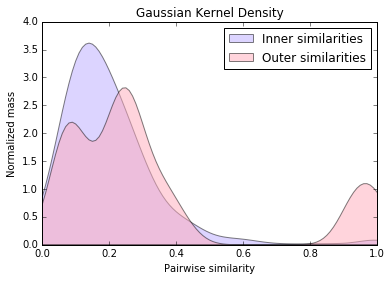

In [113]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

options={"[%s] %s (%d)" % (t.topic_id, t.query, t.document_count) : t.topic_id for t in id_topic_info.values()}


@interact(topic_id=options) #, del_id=widgets.Checkbox())
def topic_sim_kde(topic_id):
#     gt_relevant, gt_non_relevant = get_relevant(topic_id, test_data)
#     vote_relevant, vote_non_relevant = get_topic_vote_results(topic_id, judgements)
#     _, corpus = get_topic_files(FULLTEXT_FOLDER, topic_id)

    rel_doc_texts, non_rel_doc_texts = topic_rel(topic_id)
    
    # TODO(andrei): actually use this control!
#     should_del_diag = del_id
    print("Del diag: {0}".format(should_del_diag))
    
    bandwidth = 0.05
    X_plot = np.arange(-0.3, 1.3, 0.01).reshape(-1, 1)

    kde_inner = kde(rel_doc_texts, bandwidth=bandwidth)
    log_dens_inner = kde_inner.score_samples(X_plot)
    kde_outer = kde(non_rel_doc_texts, bandwidth=bandwidth)
    log_dens_outer = kde_outer.score_samples(X_plot)

    #plt.hist(flat_sim, bins=15, color="green", alpha=0.5, normed=True)
    #plt.fill(X_plot, np.exp(log_dens), fc='#AAAAFF', alpha=0.5)
    plt.title("Gaussian Kernel Density")
    plt.xlabel("Pairwise similarity")
    plt.ylabel("Normalized mass")

    plt.fill(X_plot, np.exp(log_dens_inner), fc='#BBAAFF', alpha=0.5, label="Inner similarities")
    plt.fill(X_plot, np.exp(log_dens_outer), fc='#FFAABB', alpha=0.5, label="Outer similarities")
    plt.legend()
    plt.xlim((0.0, 1.0))

Bad ones (overlap): orlando sentinel, elvish language (a little), diy audio, earthquake (!).
One in paper: 20542 how does the fly pentop computer work

# Aggregate KDE

Let's now compute the (arguably more interesting) histogram and KDE for ALL topics.

To do so, we compute a histogram for every topic, and average the histograms.

In [12]:
gt_relevant, gt_non_relevant = get_known_labels(ground_truth)
vote_relevant, vote_non_relevant = get_all_vote_results(judgements)
_, corpus = get_all_files(FULLTEXT_FOLDER)

In [13]:
print("{0} documents in corpus.".format(len(corpus)))

19636 documents in corpus.


In [79]:
rel_doc_texts = [text for doc_id, text in corpus 
                 if doc_id in gt_relevant or doc_id in vote_relevant]
non_rel_doc_texts = [text for doc_id, text in corpus
                     if doc_id in gt_non_relevant or doc_id in vote_non_relevant]
print(len(rel_doc_texts), len(non_rel_doc_texts))

1764 1323


In [15]:
topic_ids = id_topic_info.values()
# A tuple of full (relevant, non-rel) documents
all_topic_rel_non_rel = [topic_rel(t.topic_id) for t in topic_ids]
print(list(topic_ids)[16])
print(len(all_topic_rel_non_rel))

# Simple small sanity check
print("For topic #16")
print("Relevant document count: {0}".format(len(all_topic_rel_non_rel[16][0])))
print("Non-relevant document count: {0}".format(len(all_topic_rel_non_rel[16][1])))

20932:translate german to english
30
For topic #16
Relevant document count: 80
Non-relevant document count: 31


In [16]:
all_rel_sim = [np.ravel(similarity_list(rel_non_rel[0])) for rel_non_rel in all_topic_rel_non_rel]

# Outer sim = relevant vs. irrelevant!!!
all_non_rel_sim = [np.ravel(similarity_list(rel_non_rel[0], rel_non_rel[1])) for rel_non_rel in all_topic_rel_non_rel]

In [18]:
all_rel_sim_1d = np.concatenate(all_rel_sim)
all_non_rel_sim_1d = np.concatenate(all_non_rel_sim)

print(all_rel_sim_1d.shape)
print(all_non_rel_sim_1d.shape)

(111560,)
(69777,)


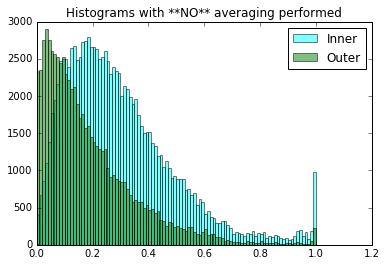

In [109]:
# hist_rel_1d = np.histogram(all_rel_sim_1d, bins=100)[0]
_ = plt.hist(all_rel_sim_1d, bins=100, color='cyan', alpha=0.5, label="Inner")
_ = plt.hist(all_non_rel_sim_1d, bins=100, color='green', alpha=0.5, label="Outer")
plt.legend()
plt.title("Histograms with **NO** averaging performed")

(111560,)
(160, 1)


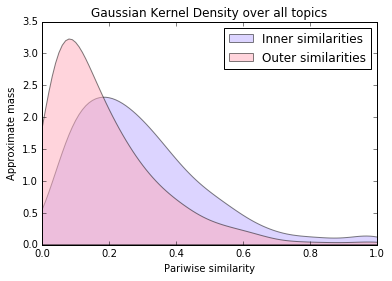

In [20]:
bandwidth = 0.05
X_plot = np.arange(-0.3, 1.3, 0.01).reshape(-1, 1)
    
print(all_rel_sim_1d.shape)
print(X_plot.shape)
    
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(all_rel_sim_1d.reshape(-1, 1))
log_dens_inner = kde.score_samples(X_plot)

kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(all_non_rel_sim_1d.reshape(-1, 1))
log_dens_outer = kde.score_samples(X_plot)

plt.title("Gaussian Kernel Density over all topics")

plt.fill(X_plot, np.exp(log_dens_inner), fc='#BBAAFF', alpha=0.5, label="Inner similarities")
plt.fill(X_plot, np.exp(log_dens_outer), fc='#FFAABB', alpha=0.5, label="Outer similarities")
plt.xlim((0.0, 1.0))
plt.xlabel("Pariwise similarity")
plt.ylabel("Approximate mass")
plt.legend()

## Old aggregate hist/kde code

In [21]:
# The [1] is because 'np.histogram' doesn't just return the histogram! (See docs)
BIN_COUNT = 50
all_rel_hist = [np.histogram(rs, bins=BIN_COUNT)[0] for rs in all_rel_sim]
all_rel_hist = np.array(all_rel_hist)

all_non_rel_hist = [np.histogram(rs, bins=BIN_COUNT)[0] for rs in all_non_rel_sim]
all_non_rel_hist = np.array(all_non_rel_hist)

In [22]:
print(all_rel_hist.shape)
print(all_non_rel_hist.shape)

(30, 50)
(30, 50)


In [23]:
all_rel_hist_avg = np.mean(all_rel_hist, axis=0)
all_non_rel_hist_avg = np.mean(all_non_rel_hist, axis=0)

In [ ]:
# plt.bar(np.linspace(0, 1, all_rel_hist_avg.shape[0]),
#         all_rel_hist_avg,
#         width=1/all_rel_hist_avg.shape[0],
#         color='red', alpha=0.5,
#         label="Inner similarities")
# plt.bar(np.linspace(0, 1, all_non_rel_hist_avg.shape[0]),
#         all_non_rel_hist_avg,
#         width=1/all_non_rel_hist_avg.shape[0],
#         alpha=0.5,
#         label="Outer similarities")
# plt.title("Hacky inner/outer similarity histogram")
# plt.legend()
# plt.ylabel("Number of documents")
# plt.xlabel("Pairwise similarity")

In [ ]:
# _ = plt.hist(rel_similarities.reshape(-1, 1), 100)
# plt.title("Inner similarities")

In [ ]:
# _ = plt.hist(non_rel_similarities.reshape(-1, 1), 100)
# plt.title("Outer similarities")

In [ ]:
# rel_doc_texts = [text for doc_id, text in corpus 
#                  if doc_id in gt_relevant or doc_id in vote_relevant]
# non_rel_doc_texts = [text for doc_id, text in corpus
#                      if doc_id in gt_non_relevant or doc_id in vote_non_relevant]

# bandwidth = 0.05
# X_plot = np.arange(-0.3, 1.3, 0.005).reshape(-1, 1)
# #kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(flat_sim)
# #log_dens = kde.score_samples(X_plot)

# print("Computing inner KDE.")
# kde_inner = kde(rel_doc_texts)
# log_dens_inner = kde_inner.score_samples(X_plot)

# print("Computing outer KDE.")
# kde_outer = kde(non_rel_doc_texts)
# log_dens_outer = kde_outer.score_samples(X_plot)

# #plt.hist(flat_sim, bins=15, color="green", alpha=0.5, normed=True)
# #plt.fill(X_plot, np.exp(log_dens), fc='#AAAAFF', alpha=0.5)
# plt.title("Gaussian Kernel Density")

# print("Plotting...")
# plt.fill(X_plot, np.exp(log_dens_inner), fc='#BBAAFF', alpha=0.5, label="Inner similarities")
# plt.fill(X_plot, np.exp(log_dens_outer), fc='#FFAABB', alpha=0.5, label="Outer similarities")
# plt.legend()
# print("Finished.")


# Using paragraph vectors

Employing par2vec instead of tf--idf representations should give us an even better-defined discrepancies between the two (inner, outer) histograms.

**Note: this toy example is insufficient.** We need to pre-train doc2vec on a huge corpus, such as Wikipedia, and then generate our document vectors.

In [24]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import *

print(len(corpus))
print(len(rel_doc_texts))
print(len(non_rel_doc_texts))

19636
1764
1323


In [43]:
import re
import string

table = str.maketrans({key: None for key in string.punctuation})

def preprocess(s):
    no_punct = s.translate(table)
    no_multi_ws = re.sub('\s+', ' ', no_punct)
    
    return no_multi_ws

In [49]:
tagged_documents = []
doc_count = len(corpus)
for doc_id, (doc_name, doc) in enumerate(corpus):    
    if (doc_id + 1) % 1000 == 0:
        print("{0}/{1}".format(doc_id, doc_count))
    words = preprocess(doc).split()
    td = TaggedDocument(words=words, tags=[doc_id])
    tagged_documents.append(td)

In [50]:
print(len(tagged_documents))

19636


In [58]:
# Use size 100, as in Piyush's paper.
d2v = Doc2Vec(documents=tagged_documents, workers=-1, size=100)

In [59]:
# Note: even though the corpus isn't very big, gensim is just blazing fast.

In [62]:
d2v.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

**This sort of tests seem to fail on our (rather small) corpus!**

In [61]:
d2v.most_similar(positive=['woman', 'king'], negative=['man'])

[('Dottailed', 0.4037927985191345),
 ('urnschemasmicrosoftcomofficesmarttags', 0.39747145771980286),
 ('Remarks', 0.3935852646827698),
 ('Mejia', 0.388798326253891),
 ('comittee', 0.3867296576499939),
 ('Marcellus', 0.383817583322525),
 ('Amethyst', 0.3760608434677124),
 ('DEWES', 0.3733574151992798),
 ('heredity6', 0.37293174862861633),
 ('magne', 0.36834555864334106)]

In [66]:
d2v.vector_size

100

In [71]:
isinstance(d2v.docvecs[0], np.ndarray)

True

In [100]:
doc_name_to_vec = {}
for idx, (doc_name, _) in enumerate(corpus):
    # Ensure doc vectors are always positive, without affecting their
    # cosine similarities, but keeping them always positive.
    doc_name_to_vec[doc_name] = d2v.docvecs[idx] + 0.005

In [101]:
len(doc_name_to_vec)

19636

In [102]:
all_vecs = np.array(d2v.docvecs)
print(all_vecs.shape)

print(np.min(all_vecs), np.max(all_vecs))

(19636, 100)
-0.00499999 0.005


(19636, 100)

In [103]:
rel_doc_vecs = np.array([doc_name_to_vec[doc_id] for doc_id, _ in corpus 
                if doc_id in gt_relevant or doc_id in vote_relevant])
non_rel_doc_vecs = np.array([doc_name_to_vec[doc_id] for doc_id, _ in corpus
                    if doc_id in gt_non_relevant or doc_id in vote_non_relevant])

In [104]:
print(len(rel_doc_vecs), len(non_rel_doc_vecs))

1764 1323


In [105]:
vec_sims_in = cosine_similarity(rel_doc_vecs)

In [106]:
vec_sims_in.shape

(1764, 1764)

In [118]:
all_topic_rel_non_rel_ids = []
for t in topic_ids:
    rel_ids, non_rel_ids = topic_rel(t.topic_id, full_text=False)
    rel_ids = [doc_name_to_vec[doc_id] for doc_id in rel_ids]
    non_rel_ids = [doc_name_to_vec[doc_id] for doc_id in non_rel_ids]
    all_topic_rel_non_rel_ids.append((rel_ids, non_rel_ids))

In [119]:
all_rel_sim_vec = [np.ravel(cosine_similarity(rel_non_rel[0])) for rel_non_rel in all_topic_rel_non_rel_ids]

# Outer sim = relevant vs. irrelevant!!!
all_non_rel_sim_vec = [np.ravel(cosine_similarity(rel_non_rel[0], rel_non_rel[1])) for rel_non_rel in all_topic_rel_non_rel_ids]

In [121]:
all_rel_sim_vec_1d = np.concatenate(all_rel_sim_vec)
all_non_rel_sim_vec_1d = np.concatenate(all_non_rel_sim_vec)

print(all_rel_sim_1d.shape)
print(all_non_rel_sim_1d.shape)

print(all_rel_sim_vec_1d.shape)
print(all_non_rel_sim_vec_1d.shape)

(111560,)
(69777,)
(113325,)
(69777,)


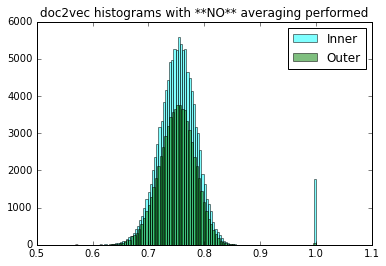

In [122]:
_ = plt.hist(all_rel_sim_vec_1d, bins=100, color='cyan', alpha=0.5, label="Inner")
_ = plt.hist(all_non_rel_sim_vec_1d, bins=100, color='green', alpha=0.5, label="Outer")
plt.legend()
plt.title("doc2vec histograms with **NO** averaging performed")